## Plot results of multi-omics classification experiments

In these experiments, we compare elastic net logistic regression models using multiple data types to models using only a single data type. We're not doing anything particularly fancy here, just concatenating the feature sets (genes or CpG probes) from the individual data types to create a "multi-omics" model.

For now, we're just doing this for gene expression and the two methylation datasets.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
BAYES_OPT = False
MLP = True

if BAYES_OPT:
    results_dir = Path(
        cfg.results_dirs['multimodal'],
        'bayes_opt',
        'gene'
    ).resolve()
    unimodal_results_dir = Path(
        cfg.results_dirs['multimodal'],
        'bayes_opt',
        'gene'
    )
elif MLP:
    results_dir = Path(
        cfg.results_dirs['multimodal'],
        'mlp_pilot',
        'gene'
    ).resolve()
    unimodal_results_dir = Path(
        cfg.results_dirs['multimodal'],
        'mlp_pilot',
        'gene'
    )
else:
    results_dir = Path(
        cfg.results_dirs['multimodal'],
        'compressed_shuffle_cancer_type',
        'gene'
    ).resolve()
    unimodal_results_dir = Path(
        cfg.results_dirs['mutation'],
        'methylation_results_shuffle_cancer_type',
        'gene'
    )

# if True, save figures to ./images directory
SAVE_FIGS = True

# if True, plot AUROC instead of AUPR
PLOT_AUROC = False
if PLOT_AUROC:
    plot_metric = 'auroc'
    images_dir = Path(cfg.images_dirs['multimodal'], 'auroc')
else:
    plot_metric = 'aupr'
    if MLP:
        images_dir = Path(cfg.images_dirs['multimodal'], 'mlp')
    else:
        images_dir = Path(cfg.images_dirs['multimodal'])

## Results with compressed features (figures in main paper)

We'll also look at results with raw features later, those figures go in the supplement.

### Compare raw results

In [3]:
# load raw data
if MLP:
    results_df = au.load_compressed_prediction_results(results_dir,
                                                       'gene',
                                                       multimodal=True)
    results_df = results_df[(results_df.n_dims == 5000) &
                            (results_df.training_data.str.contains('\.'))].copy()
    results_df.drop(columns='n_dims', inplace=True)
else:
    results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# drop TET2 for now
results_df = results_df[~(results_df.identifier == 'TET2')].copy()

# make sure that we have data for all data types and for two replicates (random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.identifier.unique())
print(results_df.training_data.unique())
results_df.head()

(1152, 9)
[42  1]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['me_27k.me_450k' 'expression.me_450k' 'expression.me_27k'
 'expression.me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.99992,0.99991,TP53,me_27k.me_450k,signal,42,train,0,gene
1,0.85381,0.82512,TP53,me_27k.me_450k,signal,42,test,0,gene
2,0.99992,0.99991,TP53,me_27k.me_450k,signal,42,cv,0,gene
3,0.99988,0.99987,TP53,me_27k.me_450k,signal,42,train,1,gene
4,0.85370,0.82323,TP53,me_27k.me_450k,signal,42,test,1,gene


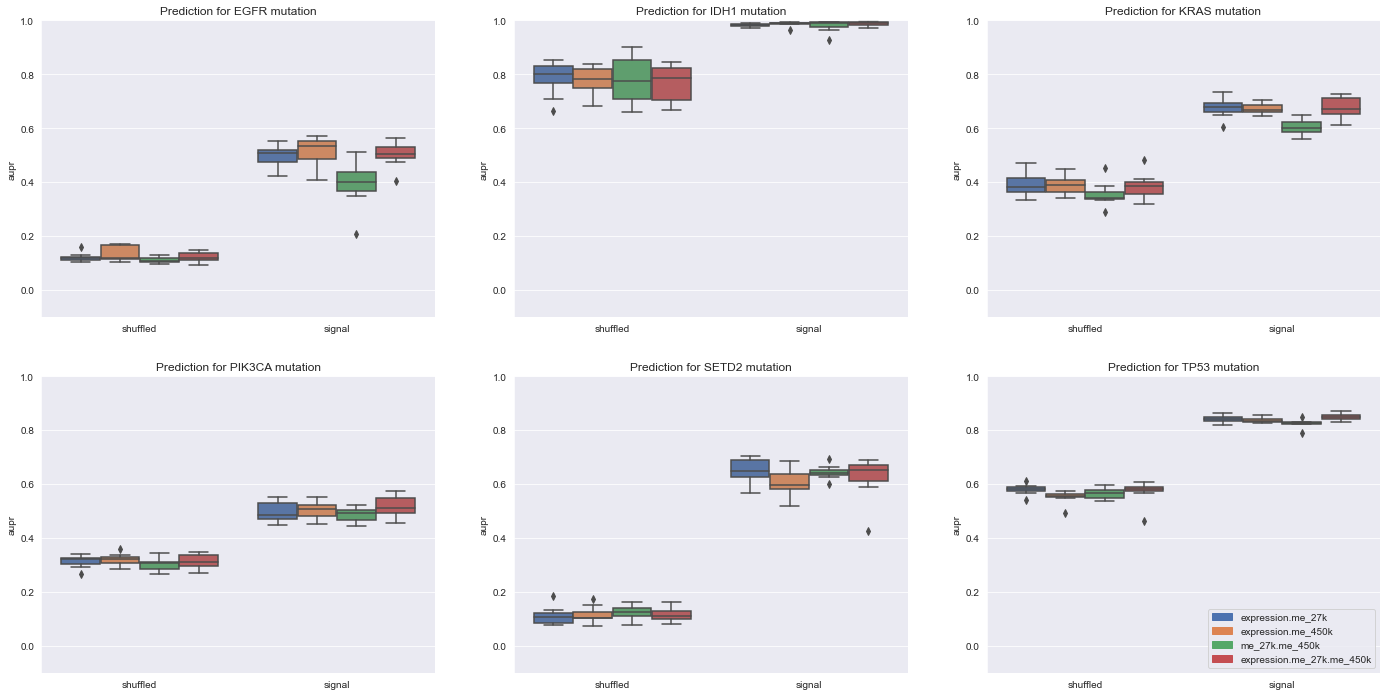

In [4]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (24, 12)})
fig, axarr = plt.subplots(2, 3)
results_df.sort_values(by=['identifier', 'signal', 'training_data'], inplace=True)

data_order =['expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

plu.plot_multi_omics_raw_results(results_df,
                                 axarr,
                                 data_order,
                                 metric=plot_metric)

handles = []
for ix, data in enumerate(data_order):
    handle = mpatches.Patch(color=sns.color_palette()[ix], label=data)
    handles.append(handle)

axarr[1, 2].legend(handles=handles, loc='lower right')

### Compare single-omics and multi-omics results

In [5]:
# get results from unimodal prediction (individual data types) to compare with
# load expression and me_27k results
u_results_df = au.load_compressed_prediction_results(unimodal_results_dir, 'gene')
u_results_df = u_results_df[(u_results_df.n_dims == 5000)].copy()
u_results_df.drop(columns='n_dims', inplace=True)

# make sure data loaded matches our expectations
print(u_results_df.training_data.unique())
print(u_results_df.seed.unique())

['expression' 'me_27k' 'me_450k']
[42  1]


In [6]:
# first, concatenate the unimodal results and the multimodal results
all_results_df = pd.concat((results_df, u_results_df))

print(all_results_df.shape)
print(all_results_df.training_data.unique())
all_results_df.head()

(2016, 9)
['expression.me_27k' 'expression.me_27k.me_450k' 'expression.me_450k'
 'me_27k.me_450k' 'expression' 'me_27k' 'me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,1.00000,1.00000,EGFR,expression.me_27k,shuffled,1,train,0,gene
1,0.55140,0.16045,EGFR,expression.me_27k,shuffled,1,test,0,gene
2,1.00000,1.00000,EGFR,expression.me_27k,shuffled,1,cv,0,gene
3,1.00000,1.00000,EGFR,expression.me_27k,shuffled,1,train,1,gene
4,0.48136,0.10219,EGFR,expression.me_27k,shuffled,1,test,1,gene


In [7]:
# then, for each training data type, get the AUPR difference between signal and shuffled
compare_df = pd.DataFrame()
for training_data in all_results_df.training_data.unique():
    all_results_df.sort_values(by=['seed', 'fold'], inplace=True)
    data_compare_df = au.compare_control_ind(
        all_results_df[all_results_df.training_data == training_data],
        identifier='identifier',
        metric=plot_metric,
        verbose=True
    )
    data_compare_df['training_data'] = training_data
    data_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_df = pd.concat((compare_df, data_compare_df))
    
compare_df.head(10)

,gene,seed,fold,delta_aupr,training_data
0,EGFR,1,0,0.35513,expression.me_27k
1,EGFR,1,1,0.41130,expression.me_27k
2,EGFR,1,2,0.39012,expression.me_27k
3,EGFR,1,3,0.30395,expression.me_27k
4,EGFR,42,0,0.34607,expression.me_27k
5,EGFR,42,1,0.35181,expression.me_27k
6,EGFR,42,2,0.43596,expression.me_27k
7,EGFR,42,3,0.42728,expression.me_27k
8,IDH1,1,0,0.16849,expression.me_27k
9,IDH1,1,1,0.19334,expression.me_27k


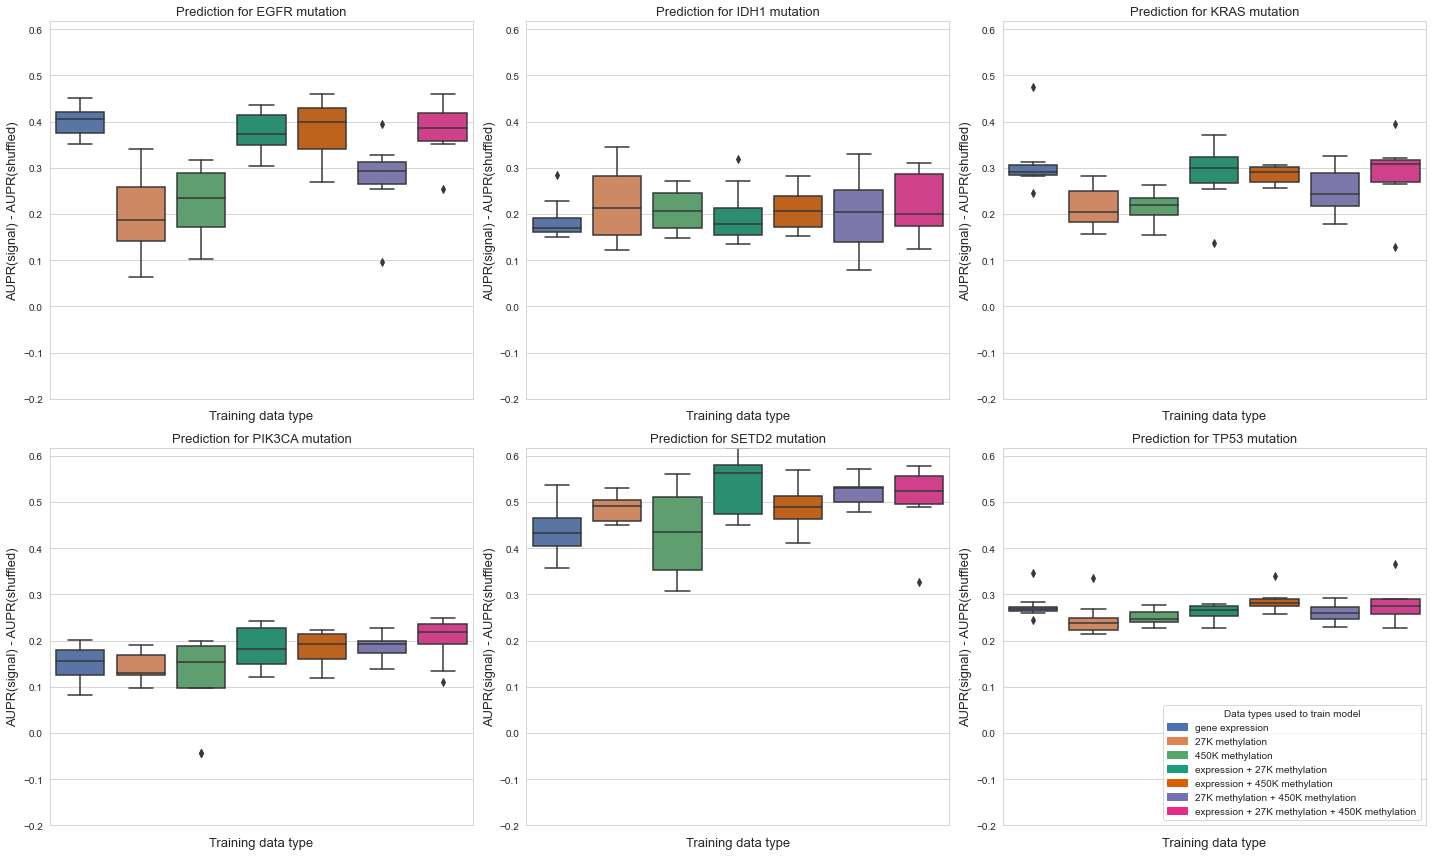

In [8]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (20, 12)})
sns.set_style('whitegrid')

# fig, axarr = plt.subplots(2, 4)
fig, axarr = plt.subplots(2, 3)
compare_df = (
    compare_df[compare_df.gene.isin(results_df.identifier.unique())]
    .sort_values(by=['gene', 'training_data'])
).copy()

data_names = {
    'expression': 'gene expression',
    'me_27k': '27K methylation',
    'me_450k': '450K methylation',
    'expression.me_27k': 'expression + 27K methylation',
    'expression.me_450k': 'expression + 450K methylation',
    'me_27k.me_450k': '27K methylation + 450K methylation',
    'expression.me_27k.me_450k': 'expression + 27K methylation + 450K methylation'
}

# we want to use the same colors as other figures for the individual
# data types, but different colors for the multi-omics models
colors = sns.color_palette()[:3] + sns.color_palette('Dark2')[:4]

plu.plot_multi_omics_results(compare_df,
                             axarr,
                             data_names,
                             colors,
                             metric=plot_metric)

handles = []
for ix, data in enumerate(list(data_names.values())):
    handle = mpatches.Patch(color=colors[ix], label=data)
    handles.append(handle)
    
plt.legend(title='Data types used to train model', handles=handles, loc='lower right')
plt.tight_layout()

if SAVE_FIGS:
    svg_filename = 'multi_omics_boxes.svg'
    png_filename = 'multi_omics_boxes.png'
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / svg_filename, bbox_inches='tight')
    plt.savefig(images_dir / png_filename, dpi=300, bbox_inches='tight')

### Compare best-performing single-omics and multi-omics data types

In [9]:
# for each data type, classify it as single-omics or multi-omics
compare_df['model_type'] = 'Best single-omics'
# multi-omics data types are concatenated using dots
compare_df.loc[compare_df.training_data.str.contains('\.'), 'model_type'] = 'Best multi-omics'
print(compare_df.training_data.unique())
compare_df[compare_df.gene == 'TP53'].head(10)

['expression' 'expression.me_27k' 'expression.me_27k.me_450k'
 'expression.me_450k' 'me_27k' 'me_27k.me_450k' 'me_450k']


,gene,seed,fold,delta_aupr,training_data,model_type
40,TP53,1,0,0.28311,expression,Best single-omics
41,TP53,1,1,0.26852,expression,Best single-omics
42,TP53,1,2,0.26064,expression,Best single-omics
43,TP53,1,3,0.24501,expression,Best single-omics
44,TP53,42,0,0.34596,expression,Best single-omics
45,TP53,42,1,0.26820,expression,Best single-omics
46,TP53,42,2,0.26530,expression,Best single-omics
47,TP53,42,3,0.26686,expression,Best single-omics
40,TP53,1,0,0.26604,expression.me_27k,Best multi-omics
41,TP53,1,1,0.27505,expression.me_27k,Best multi-omics


EGFR diff: 0.0199 (pval: 0.3125)
IDH1 diff: 0.0018 (pval: 0.7422)
KRAS diff: 0.0211 (pval: 0.9453)
PIK3CA diff: -0.0521 (pval: 0.0156)
SETD2 diff: -0.0492 (pval: 0.0781)
TP53 diff: -0.0102 (pval: 0.2500)


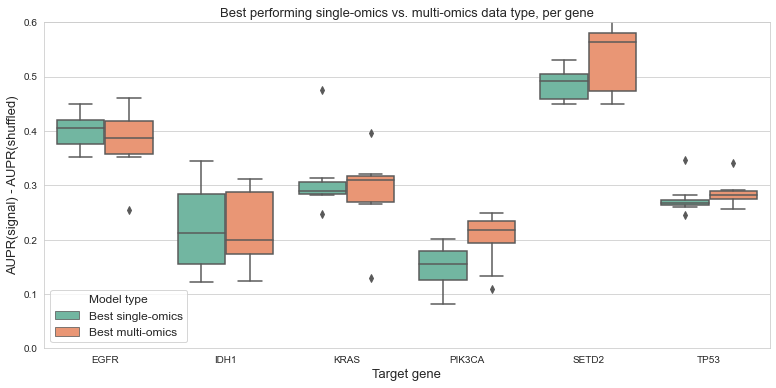

In [10]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

plu.plot_best_multi_omics_results(compare_df,
                                  ylim=(0.0, 0.6),
                                  metric=plot_metric)

if SAVE_FIGS:
    svg_filename = 'multi_omics_best_model.svg'
    png_filename = 'multi_omics_best_model.png'
    plt.savefig(images_dir / svg_filename, bbox_inches='tight')
    plt.savefig(images_dir / png_filename, dpi=300, bbox_inches='tight')

## Results with raw features (figures in supplement)

### Compare raw results

In [11]:
results_dir = Path(
    cfg.results_dirs['multimodal'],
    'raw_shuffle_cancer_type',
    'gene'
).resolve()

In [12]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# drop TET2 for now
results_df = results_df[~(results_df.identifier == 'TET2')].copy()

# make sure that we have data for all data types and for two replicates (random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.identifier.unique())
print(results_df.training_data.unique())
results_df.head()

(2016, 9)
[ 1 42]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['expression.me_450k' 'expression.me_27k.me_450k' 'expression.me_27k'
 'expression' 'me_450k' 'me_27k.me_450k' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.97175,0.96388,TP53,expression.me_450k,signal,1,train,0,gene
1,0.92924,0.89947,TP53,expression.me_450k,signal,1,test,0,gene
2,0.89397,0.85819,TP53,expression.me_450k,signal,1,cv,0,gene
3,0.97057,0.96217,TP53,expression.me_450k,signal,1,train,1,gene
4,0.91901,0.88090,TP53,expression.me_450k,signal,1,test,1,gene


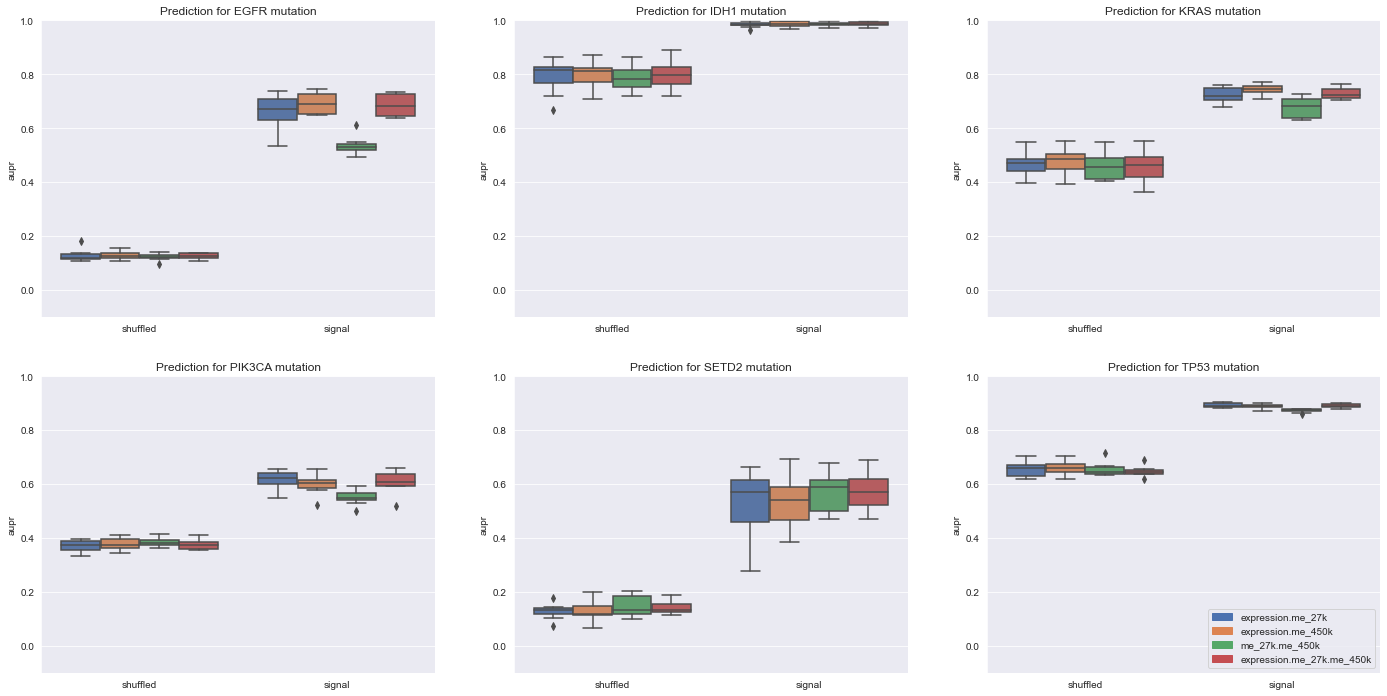

In [13]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (24, 12)})
fig, axarr = plt.subplots(2, 3)
results_df.sort_values(by=['identifier', 'signal', 'training_data'], inplace=True)

data_order =['expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

plu.plot_multi_omics_raw_results(results_df,
                                 axarr,
                                 data_order,
                                 metric=plot_metric)

handles = []
for ix, data in enumerate(data_order):
    handle = mpatches.Patch(color=sns.color_palette()[ix], label=data)
    handles.append(handle)

axarr[1, 2].legend(handles=handles, loc='lower right')

### Compare single-omics and multi-omics results

In [14]:
# then, for each training data type, get the AUPR difference between signal and shuffled
compare_df = pd.DataFrame()
for training_data in results_df.training_data.unique():
    data_compare_df = au.compare_control_ind(
        results_df[results_df.training_data == training_data],
        identifier='identifier',
        metric=plot_metric,
        verbose=True
    )
    data_compare_df['training_data'] = training_data
    data_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_df = pd.concat((compare_df, data_compare_df))
    
compare_df.head(10)

,gene,seed,fold,delta_aupr,training_data
0,EGFR,1,0,0.53208,expression
1,EGFR,1,1,0.62072,expression
2,EGFR,1,2,0.52632,expression
3,EGFR,1,3,0.57977,expression
4,EGFR,42,0,0.53319,expression
5,EGFR,42,1,0.57011,expression
6,EGFR,42,2,0.56692,expression
7,EGFR,42,3,0.61495,expression
8,IDH1,1,0,0.16770,expression
9,IDH1,1,1,0.19220,expression


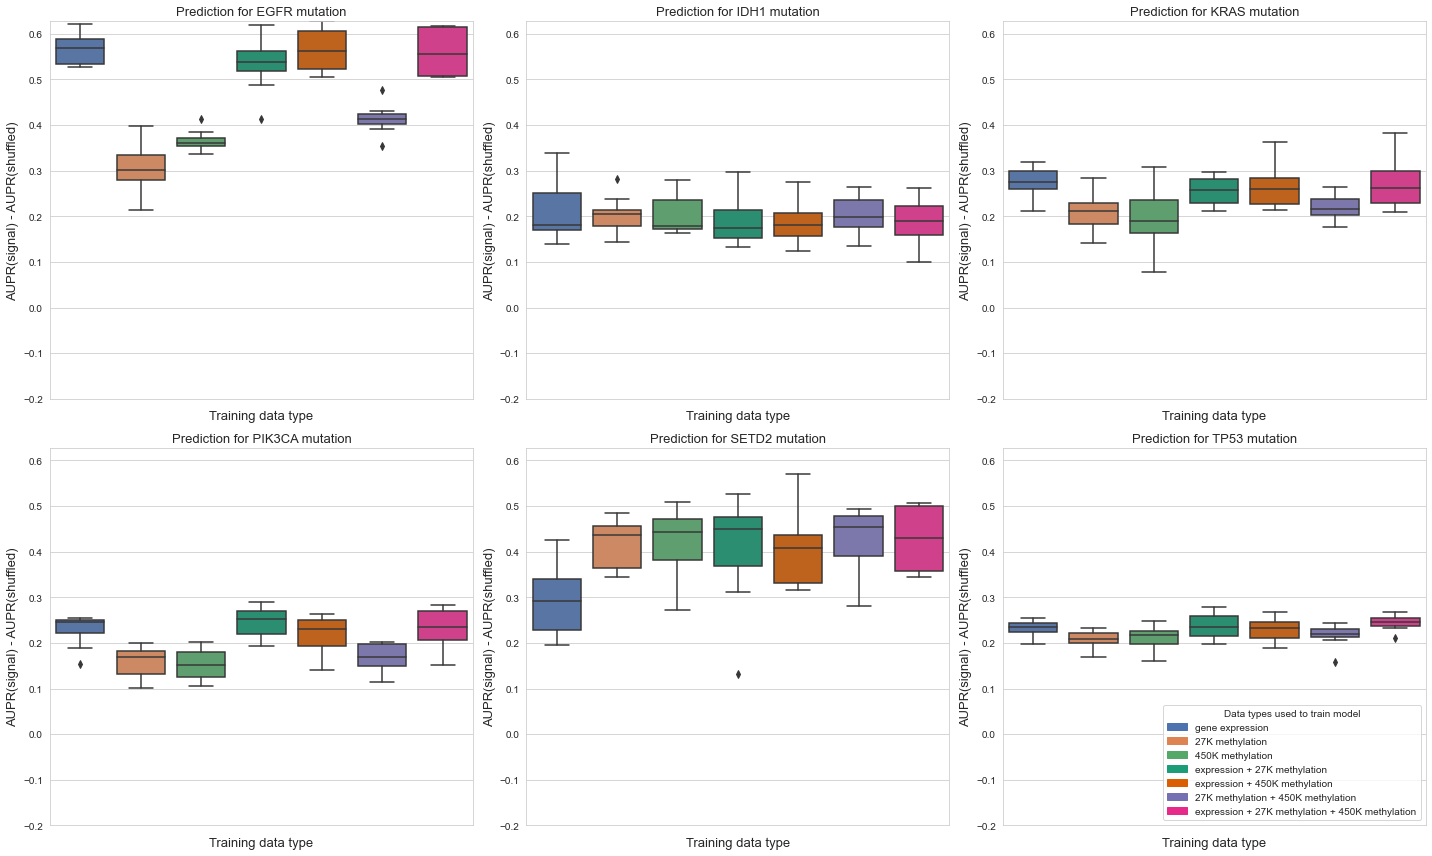

In [15]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (20, 12)})
sns.set_style('whitegrid')

# fig, axarr = plt.subplots(2, 4)
fig, axarr = plt.subplots(2, 3)
compare_df = (
    compare_df[compare_df.gene.isin(results_df.identifier.unique())]
    .sort_values(by=['gene', 'training_data'])
).copy()

data_names = {
    'expression': 'gene expression',
    'me_27k': '27K methylation',
    'me_450k': '450K methylation',
    'expression.me_27k': 'expression + 27K methylation',
    'expression.me_450k': 'expression + 450K methylation',
    'me_27k.me_450k': '27K methylation + 450K methylation',
    'expression.me_27k.me_450k': 'expression + 27K methylation + 450K methylation'
}

# we want to use the same colors as other figures for the individual
# data types, but different colors for the multi-omics models
colors = sns.color_palette()[:3] + sns.color_palette('Dark2')[:4]

plu.plot_multi_omics_results(compare_df,
                             axarr,
                             data_names,
                             colors,
                             metric=plot_metric)

handles = []
for ix, data in enumerate(list(data_names.values())):
    handle = mpatches.Patch(color=colors[ix], label=data)
    handles.append(handle)
    
plt.legend(title='Data types used to train model', handles=handles, loc='lower right')
plt.tight_layout()

if SAVE_FIGS:
    svg_filename = 'multi_omics_boxes_raw_feats.svg'
    png_filename = 'multi_omics_boxes_raw_feats.png'
    plt.savefig(images_dir / svg_filename, bbox_inches='tight')
    plt.savefig(images_dir / png_filename, dpi=300, bbox_inches='tight')

### Compare best-performing single-omics and multi-omics data types

In [16]:
# for each data type, classify it as single-omics or multi-omics
compare_df['model_type'] = 'Best single-omics'
# multi-omics data types are concatenated using dots
compare_df.loc[compare_df.training_data.str.contains('\.'), 'model_type'] = 'Best multi-omics'
print(compare_df.training_data.unique())
compare_df[compare_df.gene == 'TP53'].head(10)

['expression' 'expression.me_27k' 'expression.me_27k.me_450k'
 'expression.me_450k' 'me_27k' 'me_27k.me_450k' 'me_450k']


,gene,seed,fold,delta_aupr,training_data,model_type
40,TP53,1,0,0.24036,expression,Best single-omics
41,TP53,1,1,0.19801,expression,Best single-omics
42,TP53,1,2,0.25451,expression,Best single-omics
43,TP53,1,3,0.23719,expression,Best single-omics
44,TP53,42,0,0.20491,expression,Best single-omics
45,TP53,42,1,0.25318,expression,Best single-omics
46,TP53,42,2,0.22921,expression,Best single-omics
47,TP53,42,3,0.23097,expression,Best single-omics
40,TP53,42,0,0.19952,expression.me_27k,Best multi-omics
41,TP53,42,1,0.24045,expression.me_27k,Best multi-omics


In [ ]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

plu.plot_best_multi_omics_results(compare_df,
                                  ylim=(0.0, 0.7),
                                  metric=plot_metric)

if SAVE_FIGS:
    svg_filename = 'multi_omics_best_model_raw_feats.svg'
    png_filename = 'multi_omics_best_model_raw_feats.png'
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / svg_filename, bbox_inches='tight')
    plt.savefig(images_dir / png_filename, dpi=300, bbox_inches='tight')

EGFR diff: 0.0030 (pval: 0.6406)
IDH1 diff: 0.0116 (pval: 0.3125)
KRAS diff: 0.0023 (pval: 0.7422)
PIK3CA diff: -0.0180 (pval: 0.0547)
SETD2 diff: -0.0062 (pval: 0.8438)
TP53 diff: -0.0130 (pval: 0.0078)
